In [48]:
using LinearAlgebra
using PlotlyJS
using FFTW
using BenchmarkTools
using Kronecker

In [49]:
x = collect(LinRange(0, 127, 128)) + 1im * collect(LinRange(-64, 63, 128));

### Array Interpretation

(extracted from https://www.cs.cornell.edu/~bindel/class/cs5220-s10/slides/FFT.pdf)

Reshaping: 
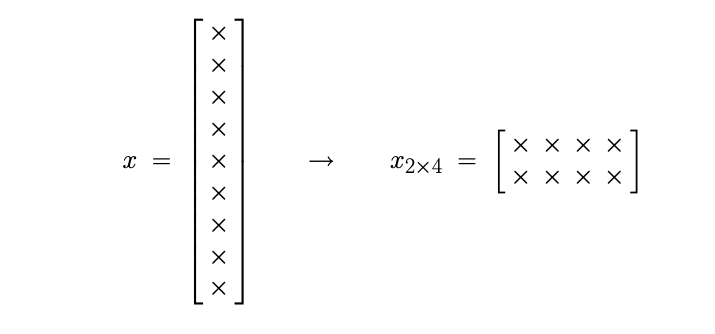

Iterations:
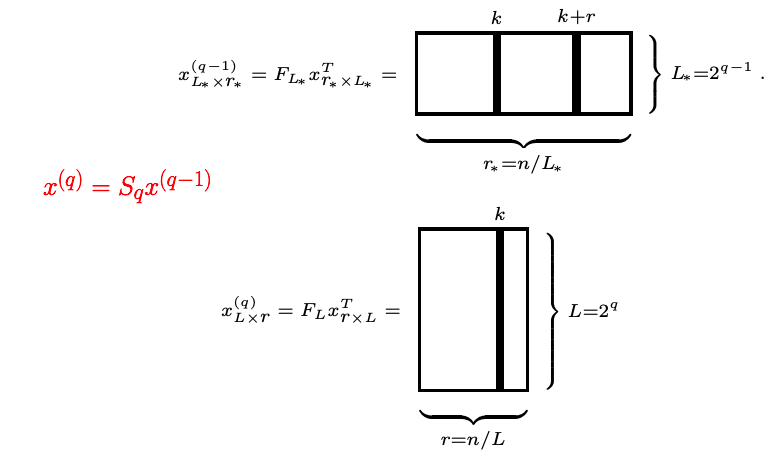

In [61]:
function stockham_transposed_fft(z, inverse = false)
    """ 
    Computes the Stockham (transpoed version) FFT/IFFT based on Algorithm 1.7.1 
    from Van Loan, C. (1992).
    """
    
    n = length(z)
    t = Int(log2(n))

    # Pre-compute roots of unity
    ω = [ [cos(2 * pi * j / 2^q) - 1im * sin(2 * pi * j/2^q) 
            for j in 0:(2^(q-1))-1] 
            for q in 1:t
        ]

    x, y = copy(z), copy(z)
    for q = 1:t  
        L = 2^q
        r = n ÷ L
        L_star = L ÷ 2

        for k = 0:r-1            
            for j = 0:L_star-1
                τ = ω[q][j + 1] * x[1 + (j + (k + r) * L_star)]
                y[1 + (j + k * L)] = x[1 + (j + k * L_star)] + τ
                y[1 + (j + L_star + k * L)] = x[1 + (j + k * L_star)] - τ
            end
        end
        x, y = y, x  # Swap buffers
    end
    return inverse ? x / n : x
end

function stockham_transposed_fft(x)
    return stockham_fft_base(x, false)
end

function stockham_transposed_ifft(y)
    return stockham_fft_base(y, true)
end


stockham_transposed_ifft (generic function with 1 method)

In [62]:
function stockham_fft_base(z, inverse = false)
    """ 
    Computes the Stockham FFT/IFFT based on Algorithm 1.7.2 
    from Van Loan, C. (1992).
    """
    
    n = length(z)
    t = Int(log2(n))
    pwr_sign = inverse ? 1 : -1

    # Create workspace 
    x, y = copy(z), copy(z)

    # Buffers: Read from `x`, write to `y`
    for q = 1:t
        L = 2^q
        r = n ÷ L
        L_star = L ÷ 2
        r_star = n ÷ L_star

        for j = 0:L_star - 1 
            ω = cos(2 * pi * j / L) + pwr_sign * 1im * sin(2 * pi * j/L)            
            for k = 0:r-1
                τ = ω * x[1 + (k + r + j * r_star)]
                y[1 + (k + j * r)] = x[1 + (k + j * r_star)] + τ
                y[1 + (k + (j + L_star) * r)] = x[1 + (k + j * r_star)] - τ
            end
        end
        
        # Swap roles: x becomes y, and y will be the next output
        x, y = y, x
    end

    return inverse ? x / n : x
end

function stockham_fft(x)
    return stockham_fft_base(x, false)
end

function stockham_ifft(y)
    return stockham_fft_base(y, true)
end


stockham_ifft (generic function with 1 method)

In [71]:
norm(stockham_ifft(stockham_fft(x)) - x, Inf)

1.6270368334683553e-12

In [72]:
norm(stockham_transposed_ifft(stockham_transposed_fft(x)) - x, Inf)

3.552713678800501e-14

#### TBD

Pease FFT